In [1]:
## Import essential libraries
import numpy as np
import pandas as pd

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Rich output (for displaying markdown stages in reports)
from IPython.display import Markdown, display

# Base Model
from xgboost import XGBRegressor

# Performance Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Custom project modules (separate .py files in repo)
from explore import *            # EDA and visualization
from FairnessAnalysis import *   # Fairness metric computation
from ModelTrainer import *       # Training baseline vs fairness-constrained models
from SHAPAnalyzer import *       # Explainability via SHAP
from FairnessAuditor import *    # Group fairness & correction pipeline

In [2]:
# =====================================================
# 📂 Data Reading & Preparation
# -----------------------------------------------------
# - Read insurance dataset
# - Remove duplicates
# - Reset index
# - One-hot encode categorical variables 
# =====================================================

display(Markdown("# Read & Prepare Data"))

# Load dataset
df, _ = read_and_verify_dataset('medical_insurance.csv')

print('Dropping duplicate records, resetting indices...')
df = df.drop_duplicates(keep='first')
df.reset_index(drop=True, inplace=True)

# Convert selected columns to categorical
cat_cols = ['children', 'smoker', 'region']

# Now, we will carry out label and one-hot encoding

# Firstly, let us define one-hot features
one_hot_features = ['region']

# Define replacement dictionary for label encoding
replace_dict = {
    'sex': {'male': 1, 'female': 0},
    'smoker': {'yes': 1, 'no': 0},
    'region': {  # This can be used if you want to replace region names with shorter codes before one-hot encoding
        'northwest': 'nw',
        'northeast': 'ne',
        'southeast': 'se',
        'southwest': 'sw'
    }
}

# Encode categorical columns -> binary & one-hot
df = ReplaceEncode(df, replace_dict=replace_dict, one_hot_features=one_hot_features, drop_first=True)
df.to_csv('cleaned_encoded_data.csv', index=False)

# Read & Prepare Data

- Reading dataset from medical_insurance.csv... done.
- Displaying first and last 5 rows:


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
2767,47,female,45.320,1,no,southeast,8569.86180
2768,21,female,34.600,0,no,southwest,2020.17700
2769,19,male,26.030,1,yes,northwest,16450.89470
2770,23,male,18.715,0,no,northwest,21595.38229



- Displaying dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2772 entries, 0 to 2771
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       2772 non-null   int64  
 1   sex       2772 non-null   object 
 2   bmi       2772 non-null   float64
 3   children  2772 non-null   int64  
 4   smoker    2772 non-null   object 
 5   region    2772 non-null   object 
 6   charges   2772 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 151.7+ KB


None


- Missing values: 0
- Duplicate rows: 1435

- Column-wise summary:
- Generating dataframe column summary... done.


,Column,Type,Unique Counts,Min,Max,Unique Sample Values
0,age,int64,47,18,64,"18, 19, 20, 21, 22 ... 60, 61, 62, 63, 64"
1,sex,object,2,female,male,"female, male"
2,bmi,float64,548,15.96,53.13,"15.96, 16.82, 17.2, 17.29, 17.39 ... 48.07, 49..."
3,children,int64,6,0,5,"0, 1, 2, 3, 4..."
4,smoker,object,2,no,yes,"no, yes"
5,region,object,4,northeast,southwest,"northeast, northwest, southeast, southwest"
6,charges,float64,1337,1121.87,63770.43,"1121.87, 1131.51, 1135.94, 1136.4, 1137.01 ......"


Dropping duplicate records, resetting indices...
🔄 Starting encoding process...
🔧 Applying label replacements...
✅ Feature: 'sex': {'male': 1, 'female': 0} : Done
✅ Feature: 'smoker': {'yes': 1, 'no': 0} : Done
✅ Feature: 'region': {'northwest': 'nw', 'northeast': 'ne', 'southeast': 'se', 'southwest': 'sw'} : Done
🎯 Applying one-hot encoding...
✅ One-hot encoded features: ['region_nw', 'region_se', 'region_sw']
🏁 Encoding process completed. Please find below Encoded Dataset:


,age,sex,bmi,children,smoker,charges,region_nw,region_se,region_sw
0,19,0,27.900,0,1,16884.92400,0,0,1
1,18,1,33.770,1,0,1725.55230,0,1,0
2,28,1,33.000,3,0,4449.46200,0,1,0
3,33,1,22.705,0,0,21984.47061,1,0,0
4,32,1,28.880,0,0,3866.85520,1,0,0
...,...,...,...,...,...,...,...,...,...
1332,50,1,30.970,3,0,10600.54830,1,0,0
1333,18,0,31.920,0,0,2205.98080,0,0,0
1334,18,0,36.850,0,0,1629.83350,0,1,0
1335,21,0,25.800,0,0,2007.94500,0,0,1


#### Experiment - Descriptive statistical report for smoker = 0, 1

In [3]:
# Descriptive statistical report for the whole data, for smoker = 0, smoker = 1
display(describe_with_features(df))
display(describe_with_features(df[df.smoker==0]))
display(describe_with_features(df[df.smoker==1]))

- Calculating enhanced descriptive statistics... done.


,age,sex,bmi,children,smoker,charges,region_nw,region_se,region_sw
count,1337.000,1337.000,1337.000,1337.000,1337.000,1337.000,1337.000,1337.000,1337.000
mean,39.222,0.505,30.663,1.096,0.205,13279.121,0.242,0.272,0.243
std,14.044,0.500,6.100,1.206,0.404,12110.360,0.429,0.445,0.429
min,18.000,0.000,15.960,0.000,0.000,1121.874,0.000,0.000,0.000
25%,27.000,0.000,26.290,0.000,0.000,4746.344,0.000,0.000,0.000
50%,39.000,1.000,30.400,1.000,0.000,9386.161,0.000,0.000,0.000
75%,51.000,1.000,34.700,2.000,0.000,16657.717,0.000,1.000,0.000
max,64.000,1.000,53.130,5.000,1.000,63770.428,1.000,1.000,1.000
cv,0.358,0.991,0.199,1.100,1.970,0.912,1.769,1.636,1.765
IQR,24.000,1.000,8.410,2.000,0.000,11911.373,0.000,1.000,0.000


- Calculating enhanced descriptive statistics... done.


,age,sex,bmi,children,smoker,charges,region_nw,region_se,region_sw
count,1063.000,1063.000,1063.000,1063.000,1063.0,1063.000,1063.000,1063.000,1063.000
mean,39.405,0.485,30.652,1.091,0.0,8440.660,0.250,0.257,0.251
std,14.076,0.500,6.046,1.218,0.0,5992.974,0.433,0.437,0.434
min,18.000,0.000,15.960,0.000,0.0,1121.874,0.000,0.000,0.000
25%,27.000,0.000,26.315,0.000,0.0,3988.884,0.000,0.000,0.000
50%,40.000,0.000,30.305,1.000,0.0,7345.727,0.000,0.000,0.000
75%,52.000,1.000,34.430,2.000,0.0,11363.019,0.500,1.000,1.000
max,64.000,1.000,53.130,5.000,0.0,36910.608,1.000,1.000,1.000
cv,0.357,1.030,0.197,1.116,NaN,0.710,1.732,1.702,1.727
IQR,25.000,1.000,8.115,2.000,0.0,7374.136,0.500,1.000,1.000


- Calculating enhanced descriptive statistics... done.


,age,sex,bmi,children,smoker,charges,region_nw,region_se,region_sw
count,274.000,274.000,274.000,274.000,274.0,274.000,274.000,274.000,274.000
mean,38.515,0.580,30.708,1.113,1.0,32050.232,0.212,0.332,0.212
std,13.923,0.494,6.319,1.157,0.0,11541.547,0.409,0.472,0.409
min,18.000,0.000,17.195,0.000,1.0,12829.455,0.000,0.000,0.000
25%,27.000,0.000,26.084,0.000,1.0,20826.244,0.000,0.000,0.000
50%,38.000,1.000,30.447,1.000,1.0,34456.348,0.000,0.000,0.000
75%,49.000,1.000,35.200,2.000,1.0,41019.207,0.000,1.000,0.000
max,64.000,1.000,52.580,5.000,1.0,63770.428,1.000,1.000,1.000
cv,0.362,0.852,0.206,1.039,0.0,0.360,1.933,1.421,1.933
IQR,22.000,1.000,9.116,2.000,0.0,20192.963,0.000,1.000,0.000


| Feature     | Property         | All Data         | Smoker = 0        | Smoker = 1        | Key Observations |
|-------------|------------------|------------------|-------------------|-------------------|------------------|
| **Age**     | Central Tendency | Mean = 39.22     | Mean = 39.41      | Mean = 38.52      | Smokers slightly younger. |
|             | Variability      | Std = 14.04, CV = 0.36 | Std = 14.08, CV = 0.36 | Std = 13.92, CV = 0.36 | Similar spread across groups. |
|             | Skewness         | 0.05             | -0.13             | 0.11              | Non-smokers slightly left-skewed. |
|             | Outliers         | Spread = 1.28     | Spread = 1.23     | Spread = 1.39     | Smokers show slightly more age outliers. |
|-------------|------------------|------------------|-------------------|-------------------|------------------|
| **Sex**     | Central Tendency | Mean = 0.505     | Mean = 0.485      | Mean = 0.580      | Smokers skew male, non-smokers female. |
|             | Variability      | CV = 0.99        | CV = 1.03         | CV = 0.85         | Less variability among smokers. |
|             | Skewness         | -2.97            | 2.91              | -2.55             | Strong skew due to binary encoding. |
|-------------|------------------|------------------|-------------------|-------------------|------------------|
| **BMI**     | Central Tendency | Mean = 30.66     | Mean = 30.65      | Mean = 30.71      | Very similar across groups. |
|             | Variability      | Std = 6.10, CV = 0.20 | Std = 6.05, CV = 0.20 | Std = 6.32, CV = 0.21 | Smokers slightly more variable. |
|             | Skewness         | 0.13             | 0.17              | 0.12              | Mild right skew in both. |
|             | Outliers         | Spread = 2.95     | Spread = 3.05     | Spread = 2.59     | Non-smokers show more BMI outliers. |
|-------------|------------------|------------------|-------------------|-------------------|------------------|
| **Charges** | Central Tendency | Mean = 13279     | Mean = 8441       | Mean = 32050      | Smokers pay ~4x more. |
|             | Variability      | Std = 12110, CV = 0.91 | Std = 5993, CV = 0.71 | Std = 11542, CV = 0.36 | Smokers have higher spread but lower CV. |
|             | Skewness         | 0.96             | 0.55              | -0.63             | Non-smokers right-skewed, smokers left-skewed. |
|             | Outliers         | Spread = 3.51     | Spread = 3.24     | Spread = 1.68     | Non-smokers have more extreme outliers. |
|-------------|------------------|------------------|-------------------|-------------------|------------------|
| **Region_SE** | Central Tendency | Mean = 0.272     | Mean = 0.257      | Mean = 0.332      | Smokers more concentrated in SE. |
|               | Variability      | CV = 1.64        | CV = 1.70         | CV = 1.42         | Smokers less variable. |
|               | Skewness         | 1.83             | 1.76              | 2.11              | Smokers show stronger skew. |
|-------------|------------------|------------------|-------------------|-------------------|------------------|

In [4]:
def define_xgb():
    ## Revised model with reduced regularization
    xgb = XGBRegressor(
        n_estimators=100,
        objective='reg:squarederror',
        random_state=42,
        
        # Regularization (reduced)
        reg_alpha=0.5,           # High L1 regularization
        reg_lambda=1.0,          # High L2 regularization
    
        # Tree complexity (relaxed slightly)
        max_depth=8,          # Do not allow deeper trees
        min_child_weight=4,   # Allow splits with 4 samples
    
        # Subsampling (unchanged for now)
        subsample=0.8,
        colsample_bytree=0.8,
    
        # Learning rate balances convergence speed and accuracy
        learning_rate=0.05
    )
    return xgb

### Experiment 1: Contribution of upsampling vs engineered features on Model Performance

#### 1a. Baseline model

🔧 Step 0: Initial Data Splitting (Stratified if possible)...
✅ Stratifying by combined columns: ['smoker', 'sex']


## **Step 1: Baseline Model Performance (Standard XGBoost)** 📊


📈 Training Baseline Model...
📊 Evaluating Baseline Model (Overall Test Set)...
RMSE: 2697.91 MAE: 1539.34 R2: 0.95
RMSE: 4314.24 MAE: 2644.39 R2: 0.85
Overall Test RMSE: 4314.24
Overall Test MAE: 2644.39
Overall Test R2: 0.85

--- Visualizing Baseline Model Performance ---

📐 Baseline Training Best-Fit Line: y = 0.9056x + 1251.21

📐 Baseline Test Best-Fit Line: y = 0.8230x + 2654.38


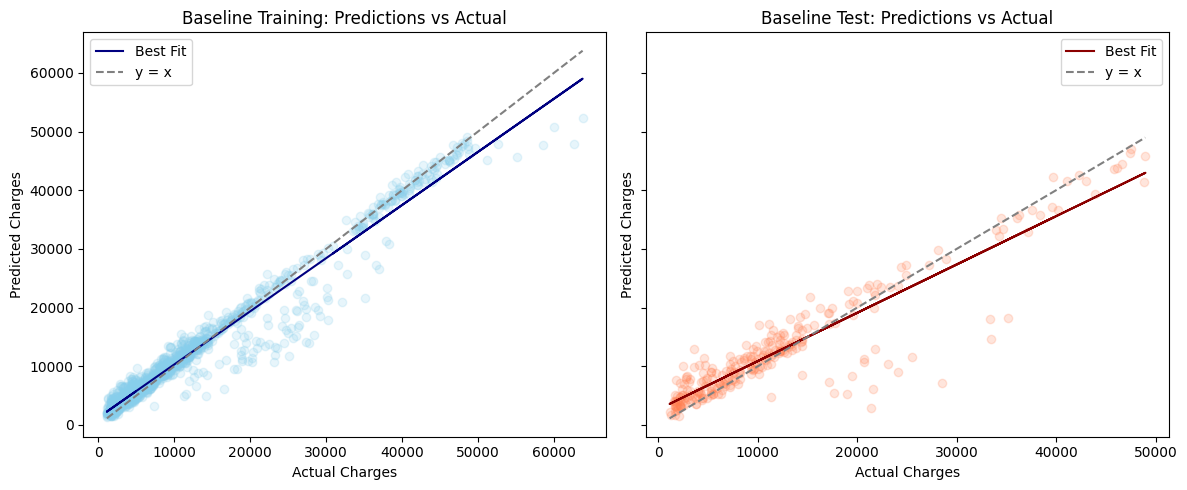

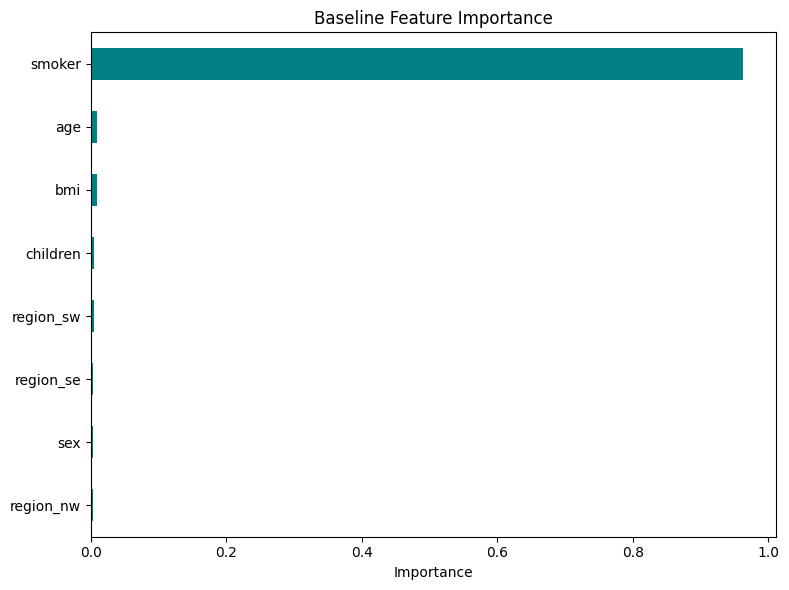


--- Collecting Group-wise Metrics for Baseline Model ---
✅ Baseline Model Evaluation Complete.


## **Step 2: Fairlearn-Constrained Model** ⚖️

✅ Dynamic `upper_bound` set to 1/3 of baseline training MAE: 513.11

📈 Training fairness-constrained model (constraints on ['smoker', 'sex'])...
This process may take longer due to fairness optimization.
⚠️ Unable to compute constraint violations on training set for Fair Model: ConditionalLossMoment.gamma() got an unexpected keyword argument 'sensitive_features'. This might happen with certain model types or if gamma calculation is complex. Safe to ignore if primarily using overall performance and group-wise metrics.

📊 Evaluating Fairlearn-Constrained Model (Overall Test Set)...
RMSE: 3078.56 MAE: 1787.25 R2: 0.94
RMSE: 4287.24 MAE: 2701.66 R2: 0.85
Overall Test RMSE: 4287.24
Overall Test MAE: 2701.66
Overall Test R2: 0.85

--- Visualizing Fairlearn-Constrained Model Performance ---

📐 Fairlearn Training Best-Fit Line: y = 0.8986x + 1468.55

📐 Fairlearn Test Best-Fit Line: y = 0.8250x + 2702.74


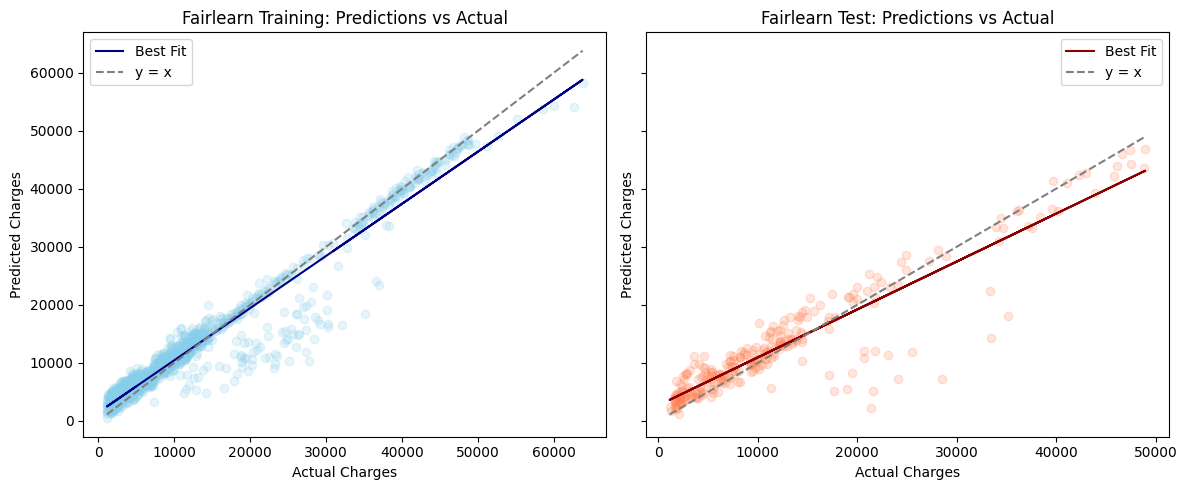


⚠️ Feature importance not available or empty for the Fairlearn model.

--- Collecting Group-wise Metrics for Fairlearn-Constrained Model ---
✅ Fairlearn Model Evaluation Complete.


## **Step 3: Hybrid Subgroup Model** 🎯


📈 Training Hybrid Subgroup Model...
🚀 Starting Hybrid Subgroup Model Training:
Non-smoker data points: 850
Smoker data points: 219
--------------------------------------------------

--- Training Standard Model for NON-SMOKERS ---
✅ Stratifying by combined columns: ['smoker', 'sex']
RMSE: 2630.24 MAE: 1518.34 R2: 0.82

--- Training FAIRNESS-AWARE Model for SMOKERS ---
✅ Stratifying by combined columns: ['smoker', 'sex']
RMSE: 1545.84 MAE: 893.84 R2: 0.98
✅ Dynamic `upper_bound` set to 1/3 of baseline training MAE: 297.95

📈 Training fairness-constrained model (constraints on ['smoker', 'sex'])...
This process may take longer due to fairness optimization.
⚠️ Unable to compute constraint violations on training set for Fair Model: ConditionalLossMoment.gamma() got an unexpected keyword argument 'sensitive_features'. This might happen with certain model types or if gamma calculation is complex. Safe to ignore if primarily using overall performance and group-wise metrics.

✅ Hybrid Subgrou

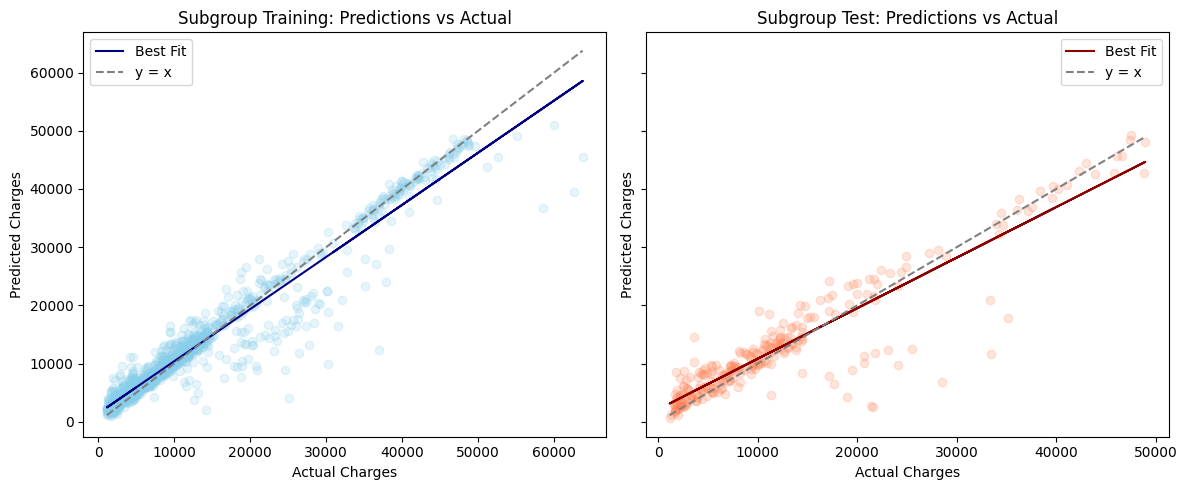


Note: Feature importance for the composite Hybrid Subgroup Model is not directly plotted here.
To inspect individual subgroup model importances, access `subgrp_model.non_smoker_model` and `subgrp_model.smoker_model`.

--- Collecting Group-wise Metrics for Hybrid Subgroup Model ---
✅ Hybrid Subgroup Model Evaluation Complete.


## **Step 4: Comparative Feature-wise Analysis** 📈⚖️🎯

Comparing MAE, MSE, and R² across Baseline, Fairlearn, and Hybrid Subgroup Models:


### Comparative Mean Absolute Error by Feature

,Feature,Group,Baseline MAE,Fairlearn MAE,Subgroup MAE
0,sex,0,2719.8846,2786.7477,2658.8289
1,sex,1,2570.0070,2617.8253,2503.4452
2,sex,Mean,2644.9458,2702.2865,2581.1370
3,sex,StdDev,74.9388,84.4612,77.6918
4,children,0,2510.1969,2456.9107,2447.2341
5,children,1,2600.1875,2666.3411,2519.6337
6,children,2,3448.3955,3636.1056,3639.2729
7,children,3,1920.2795,2361.7000,1635.6673
8,children,4,4077.5962,4111.5547,3732.1972
9,children,5,2585.7974,2039.2852,2608.2372


### Comparative Mean Squared Error by Feature

,Feature,Group,Baseline MSE,Fairlearn MSE,Subgroup MSE
0,sex,0,2.147719e+07,2.082044e+07,2.107910e+07
1,sex,1,1.579049e+07,1.597657e+07,1.666179e+07
2,sex,Mean,1.863384e+07,1.839850e+07,1.887045e+07
3,sex,StdDev,2.843351e+06,2.421933e+06,2.208657e+06
4,children,0,1.720742e+07,1.619124e+07,1.723227e+07
5,children,1,2.058484e+07,2.024821e+07,2.042207e+07
6,children,2,2.717659e+07,2.869406e+07,3.122915e+07
7,children,3,6.128979e+06,8.306549e+06,4.614206e+06
8,children,4,3.205232e+07,3.101921e+07,2.793255e+07
9,children,5,1.261836e+07,6.520514e+06,1.320010e+07


### Comparative R-squared by Feature

,Feature,Group,Baseline R2,Fairlearn R2,Subgroup R2
0,sex,0,0.7801,0.7868,0.7842
1,sex,1,0.8921,0.8909,0.8862
2,sex,Mean,0.8361,0.8389,0.8352
3,sex,StdDev,0.0560,0.0520,0.0510
4,children,0,0.8782,0.8854,0.8780
5,children,1,0.7996,0.8029,0.8012
6,children,2,0.8076,0.7969,0.7790
7,children,3,0.9210,0.8929,0.9405
8,children,4,0.6685,0.6792,0.7111
9,children,5,0.1937,0.5834,0.1566





**End of Comparative Analysis.**


In [5]:
## Define pipeline parameters
target = 'charges';  hue = 'smoker'; stratify_by = ['smoker', 'sex']
key_features = ['sex','children','smoker','region_nw', 'region_se', 'region_sw']
metrics = {"MAE": mean_absolute_error, "MSE": mean_squared_error, "R2": r2_score}
model = define_xgb()
trainer = ModelTrainer(df=df, model=model, target=target, stratify_by=stratify_by)
model_results = trainer.run_fairness_comparison_pipeline()

#### 1.b Only Feature engineered data, no upsampling

1️⃣ Binning age and BMI...
2️⃣ Creating interaction features...
3️⃣ Adding behavioral flags...
🔧 Step 0: Initial Data Splitting (Stratified if possible)...
✅ Stratifying by combined columns: ['smoker', 'sex']


## **Step 1: Baseline Model Performance (Standard XGBoost)** 📊


📈 Training Baseline Model...
📊 Evaluating Baseline Model (Overall Test Set)...
RMSE: 2600.92 MAE: 1420.60 R2: 0.96
RMSE: 4235.98 MAE: 2444.89 R2: 0.85
Overall Test RMSE: 4235.98
Overall Test MAE: 2444.89
Overall Test R2: 0.85

--- Visualizing Baseline Model Performance ---

📐 Baseline Training Best-Fit Line: y = 0.9203x + 1043.15

📐 Baseline Test Best-Fit Line: y = 0.8775x + 2072.66


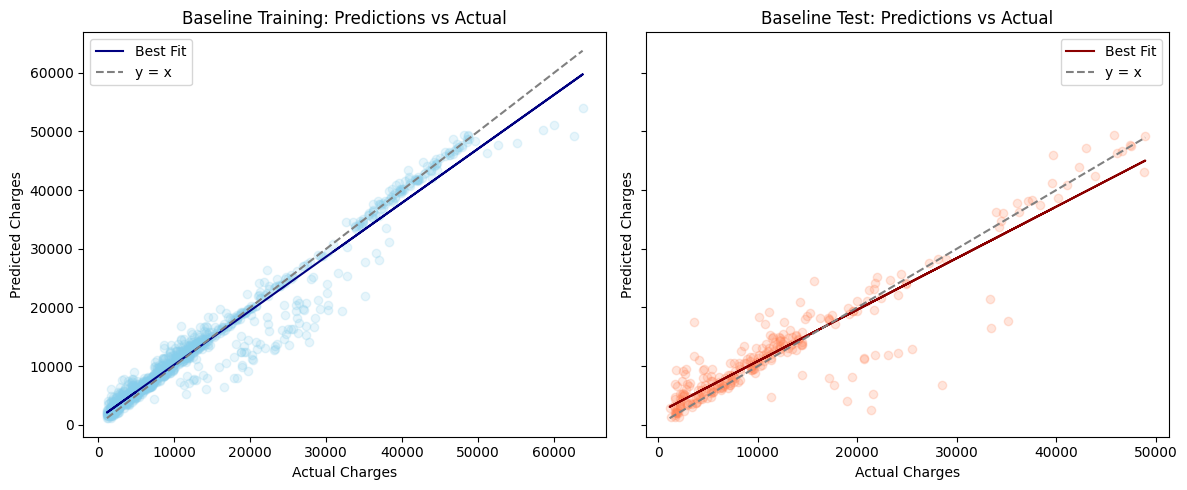

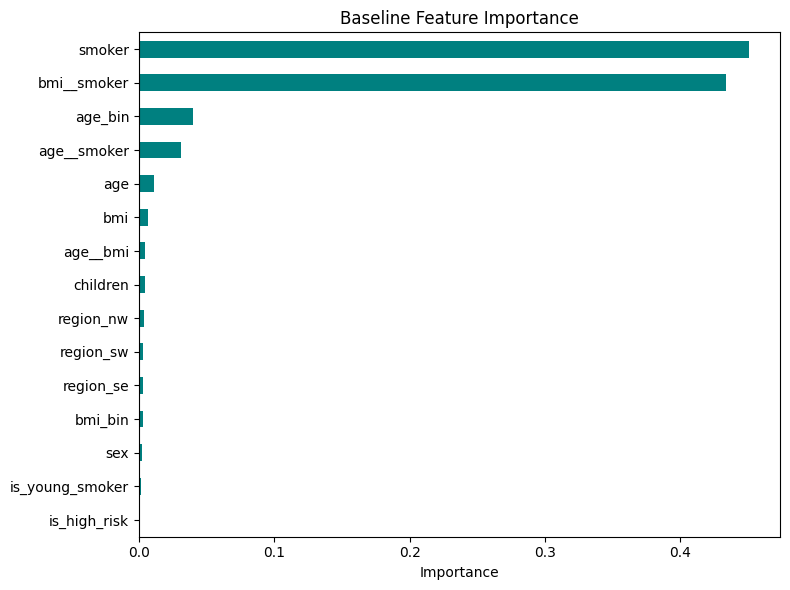


--- Collecting Group-wise Metrics for Baseline Model ---
✅ Baseline Model Evaluation Complete.


## **Step 2: Fairlearn-Constrained Model** ⚖️

✅ Dynamic `upper_bound` set to 1/3 of baseline training MAE: 473.53

📈 Training fairness-constrained model (constraints on ['smoker', 'sex'])...
This process may take longer due to fairness optimization.
⚠️ Unable to compute constraint violations on training set for Fair Model: ConditionalLossMoment.gamma() got an unexpected keyword argument 'sensitive_features'. This might happen with certain model types or if gamma calculation is complex. Safe to ignore if primarily using overall performance and group-wise metrics.

📊 Evaluating Fairlearn-Constrained Model (Overall Test Set)...
RMSE: 3029.93 MAE: 1637.69 R2: 0.94
RMSE: 4145.39 MAE: 2373.37 R2: 0.86
Overall Test RMSE: 4145.39
Overall Test MAE: 2373.37
Overall Test R2: 0.86

--- Visualizing Fairlearn-Constrained Model Performance ---

📐 Fairlearn Training Best-Fit Line: y = 0.9120x + 1222.29

📐 Fairlearn Test Best-Fit Line: y = 0.8781x + 1967.54


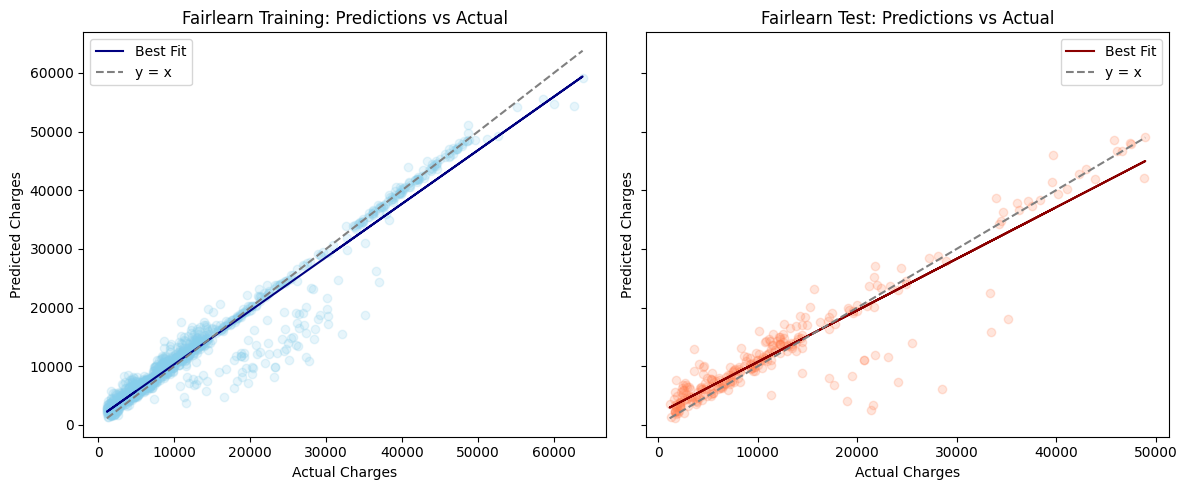


⚠️ Feature importance not available or empty for the Fairlearn model.

--- Collecting Group-wise Metrics for Fairlearn-Constrained Model ---
✅ Fairlearn Model Evaluation Complete.


## **Step 3: Hybrid Subgroup Model** 🎯


📈 Training Hybrid Subgroup Model...
🚀 Starting Hybrid Subgroup Model Training:
Non-smoker data points: 850
Smoker data points: 219
--------------------------------------------------

--- Training Standard Model for NON-SMOKERS ---
✅ Stratifying by combined columns: ['smoker', 'sex']
RMSE: 2261.18 MAE: 1277.11 R2: 0.87

--- Training FAIRNESS-AWARE Model for SMOKERS ---
✅ Stratifying by combined columns: ['smoker', 'sex']
RMSE: 1420.72 MAE: 725.38 R2: 0.98
✅ Dynamic `upper_bound` set to 1/3 of baseline training MAE: 241.79

📈 Training fairness-constrained model (constraints on ['smoker', 'sex'])...
This process may take longer due to fairness optimization.
⚠️ Unable to compute constraint violations on training set for Fair Model: ConditionalLossMoment.gamma() got an unexpected keyword argument 'sensitive_features'. This might happen with certain model types or if gamma calculation is complex. Safe to ignore if primarily using overall performance and group-wise metrics.

✅ Hybrid Subgrou

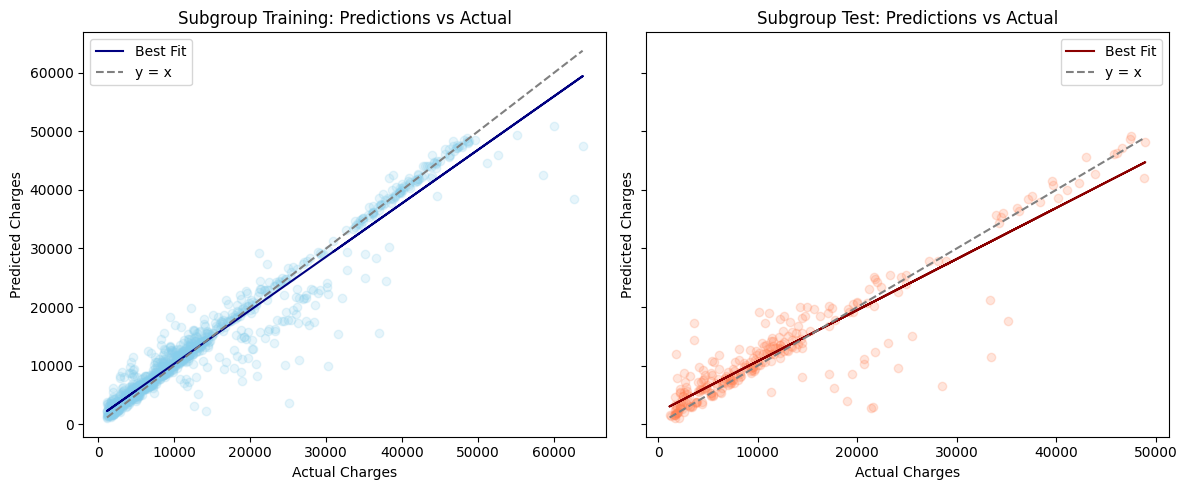


Note: Feature importance for the composite Hybrid Subgroup Model is not directly plotted here.
To inspect individual subgroup model importances, access `subgrp_model.non_smoker_model` and `subgrp_model.smoker_model`.

--- Collecting Group-wise Metrics for Hybrid Subgroup Model ---
✅ Hybrid Subgroup Model Evaluation Complete.


## **Step 4: Comparative Feature-wise Analysis** 📈⚖️🎯

Comparing MAE, MSE, and R² across Baseline, Fairlearn, and Hybrid Subgroup Models:


### Comparative Mean Absolute Error by Feature

,Feature,Group,Baseline MAE,Fairlearn MAE,Subgroup MAE
0,sex,0,2576.4393,2509.1449,2478.1748
1,sex,1,2315.2865,2239.6134,2417.2597
2,sex,Mean,2445.8629,2374.3791,2447.7172
3,sex,StdDev,130.5764,134.7657,30.4575
4,children,0,2308.4449,2272.2141,2204.3345
5,children,1,2372.1451,2323.3540,2438.8592
6,children,2,3212.6780,3079.0513,3585.0832
7,children,3,1774.5349,1634.9637,1378.5636
8,children,4,4125.6759,3734.2876,4319.2992
9,children,5,2382.4110,2550.7945,4264.9797


### Comparative Mean Squared Error by Feature

,Feature,Group,Baseline MSE,Fairlearn MSE,Subgroup MSE
0,sex,0,2.035659e+07,1.972912e+07,2.150685e+07
1,sex,1,1.556624e+07,1.467703e+07,1.651444e+07
2,sex,Mean,1.796141e+07,1.720307e+07,1.901064e+07
3,sex,StdDev,2.395175e+06,2.526045e+06,2.496204e+06
4,children,0,1.609771e+07,1.572134e+07,1.654530e+07
5,children,1,2.012229e+07,1.921907e+07,1.953276e+07
6,children,2,2.579636e+07,2.514200e+07,3.572182e+07
7,children,3,7.437759e+06,6.209065e+06,3.268370e+06
8,children,4,3.277092e+07,2.839854e+07,3.162917e+07
9,children,5,1.243131e+07,1.138290e+07,2.297048e+07


### Comparative R-squared by Feature

,Feature,Group,Baseline R2,Fairlearn R2,Subgroup R2
0,sex,0,0.7916,0.7980,0.7798
1,sex,1,0.8937,0.8998,0.8872
2,sex,Mean,0.8426,0.8489,0.8335
3,sex,StdDev,0.0510,0.0509,0.0537
4,children,0,0.8860,0.8887,0.8829
5,children,1,0.8041,0.8129,0.8098
6,children,2,0.8174,0.8220,0.7472
7,children,3,0.9041,0.9200,0.9579
8,children,4,0.6610,0.7063,0.6729
9,children,5,0.2057,0.2727,-0.4677





**End of Comparative Analysis.**


In [6]:
from transformation import *
print('1️⃣ Binning age and BMI...')
dfa = bin_continuous(df, ['age', 'bmi'], bins=5, strategy='quantile')

print('2️⃣ Creating interaction features...')
dfa = generate_interactions(dfa, ['age', 'bmi', 'smoker'], max_order=2)
print('3️⃣ Adding behavioral flags...')
dfa = create_behavior_flags(dfa)

## Define pipeline parameters
target = 'charges';  hue = 'smoker'; stratify_by = ['smoker', 'sex']
key_features = ['sex','children','smoker','region_nw', 'region_se', 'region_sw']
metrics = {"MAE": mean_absolute_error, "MSE": mean_squared_error, "R2": r2_score}
model = define_xgb()
trainer = ModelTrainer(df=dfa, model=model, target=target, stratify_by=stratify_by)
model_results = trainer.run_fairness_comparison_pipeline()

#### 1.c Only upsampling, no Feature engineered data


Upsampling dataset to balance classes in target 'smoker'



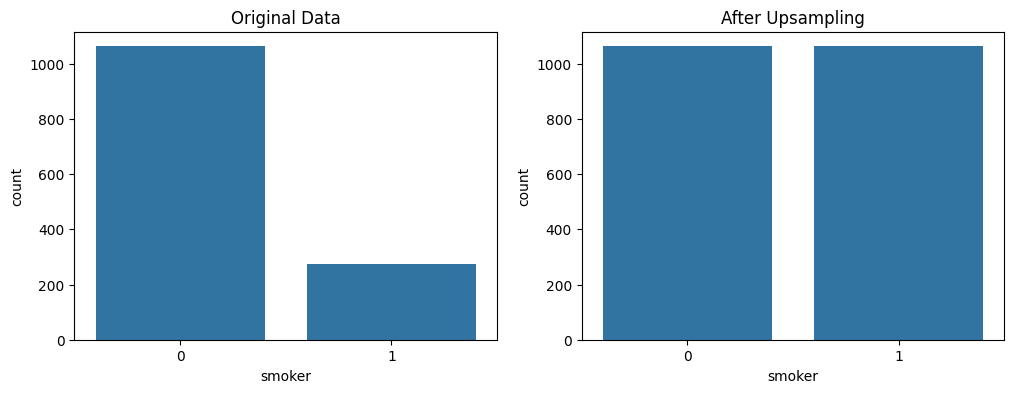

🔧 Step 0: Initial Data Splitting (Stratified if possible)...
✅ Stratifying by combined columns: ['smoker', 'sex']


## **Step 1: Baseline Model Performance (Standard XGBoost)** 📊


📈 Training Baseline Model...
📊 Evaluating Baseline Model (Overall Test Set)...
RMSE: 2590.23 MAE: 1518.82 R2: 0.97
RMSE: 3847.27 MAE: 2329.30 R2: 0.93
Overall Test RMSE: 3847.27
Overall Test MAE: 2329.30
Overall Test R2: 0.93

--- Visualizing Baseline Model Performance ---

📐 Baseline Training Best-Fit Line: y = 0.9353x + 1309.22

📐 Baseline Test Best-Fit Line: y = 0.9011x + 2303.66


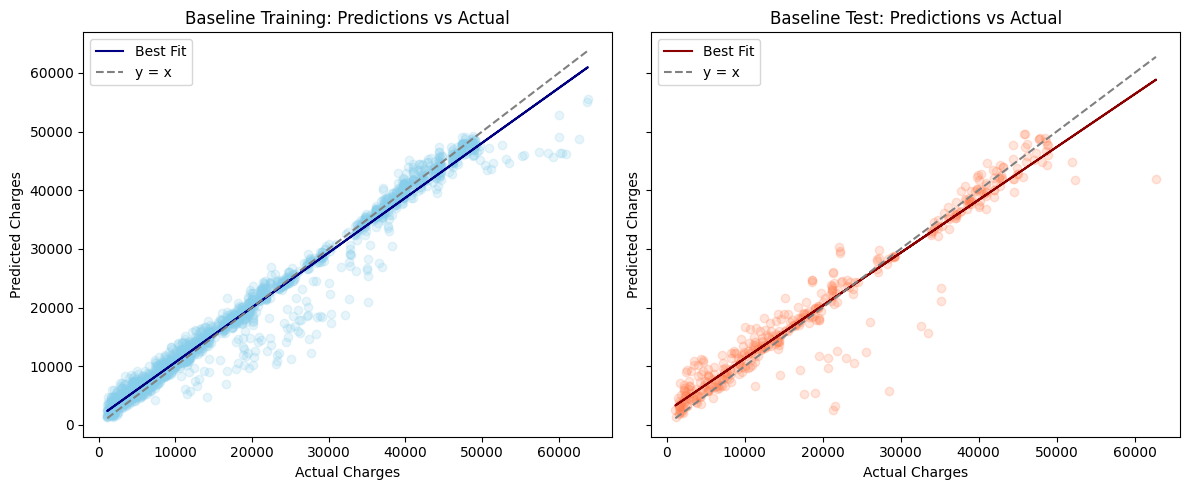

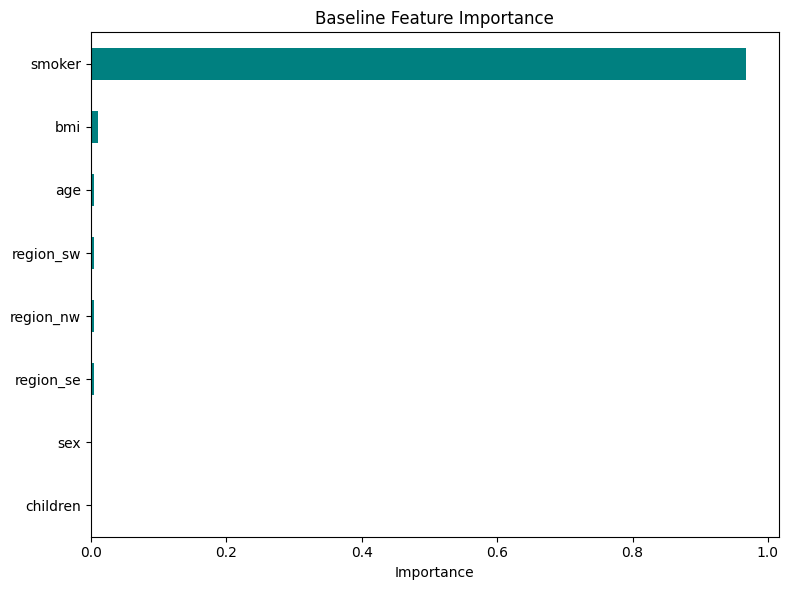


--- Collecting Group-wise Metrics for Baseline Model ---
✅ Baseline Model Evaluation Complete.


## **Step 2: Fairlearn-Constrained Model** ⚖️

✅ Dynamic `upper_bound` set to 1/3 of baseline training MAE: 506.27

📈 Training fairness-constrained model (constraints on ['smoker', 'sex'])...
This process may take longer due to fairness optimization.
⚠️ Unable to compute constraint violations on training set for Fair Model: ConditionalLossMoment.gamma() got an unexpected keyword argument 'sensitive_features'. This might happen with certain model types or if gamma calculation is complex. Safe to ignore if primarily using overall performance and group-wise metrics.

📊 Evaluating Fairlearn-Constrained Model (Overall Test Set)...
RMSE: 2643.04 MAE: 1533.25 R2: 0.97
RMSE: 3810.03 MAE: 2298.06 R2: 0.93
Overall Test RMSE: 3810.03
Overall Test MAE: 2298.06
Overall Test R2: 0.93

--- Visualizing Fairlearn-Constrained Model Performance ---

📐 Fairlearn Training Best-Fit Line: y = 0.9338x + 1336.42

📐 Fairlearn Test Best-Fit Line: y = 0.9043x + 2233.77


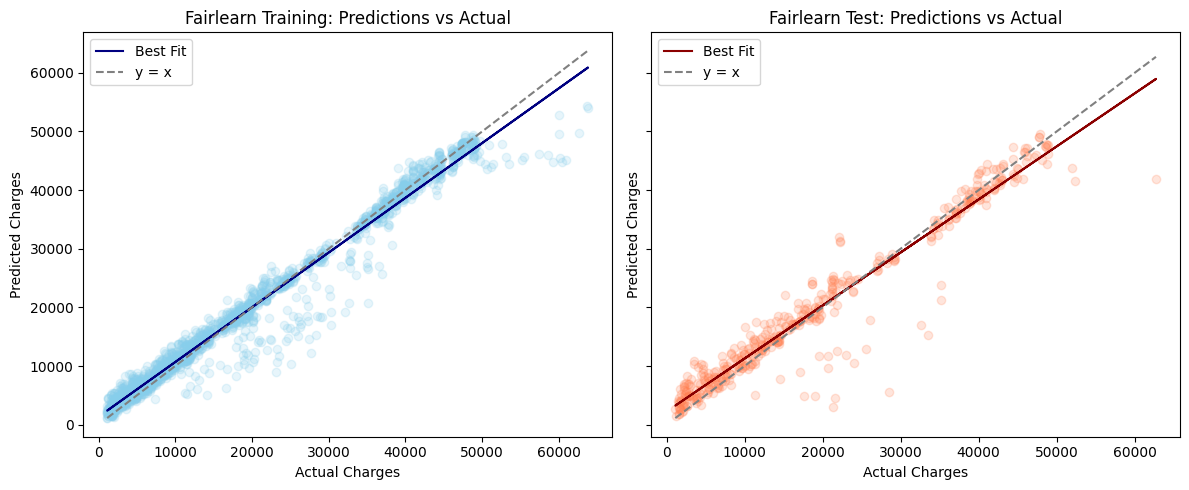


⚠️ Feature importance not available or empty for the Fairlearn model.

--- Collecting Group-wise Metrics for Fairlearn-Constrained Model ---
✅ Fairlearn Model Evaluation Complete.


## **Step 3: Hybrid Subgroup Model** 🎯


📈 Training Hybrid Subgroup Model...
🚀 Starting Hybrid Subgroup Model Training:
Non-smoker data points: 850
Smoker data points: 850
--------------------------------------------------

--- Training Standard Model for NON-SMOKERS ---
✅ Stratifying by combined columns: ['smoker', 'sex']
RMSE: 2622.74 MAE: 1478.43 R2: 0.81

--- Training FAIRNESS-AWARE Model for SMOKERS ---
✅ Stratifying by combined columns: ['smoker', 'sex']
RMSE: 1820.00 MAE: 1051.46 R2: 0.98
✅ Dynamic `upper_bound` set to 1/3 of baseline training MAE: 350.49

📈 Training fairness-constrained model (constraints on ['smoker', 'sex'])...
This process may take longer due to fairness optimization.
⚠️ Unable to compute constraint violations on training set for Fair Model: ConditionalLossMoment.gamma() got an unexpected keyword argument 'sensitive_features'. This might happen with certain model types or if gamma calculation is complex. Safe to ignore if primarily using overall performance and group-wise metrics.

✅ Hybrid Subgro

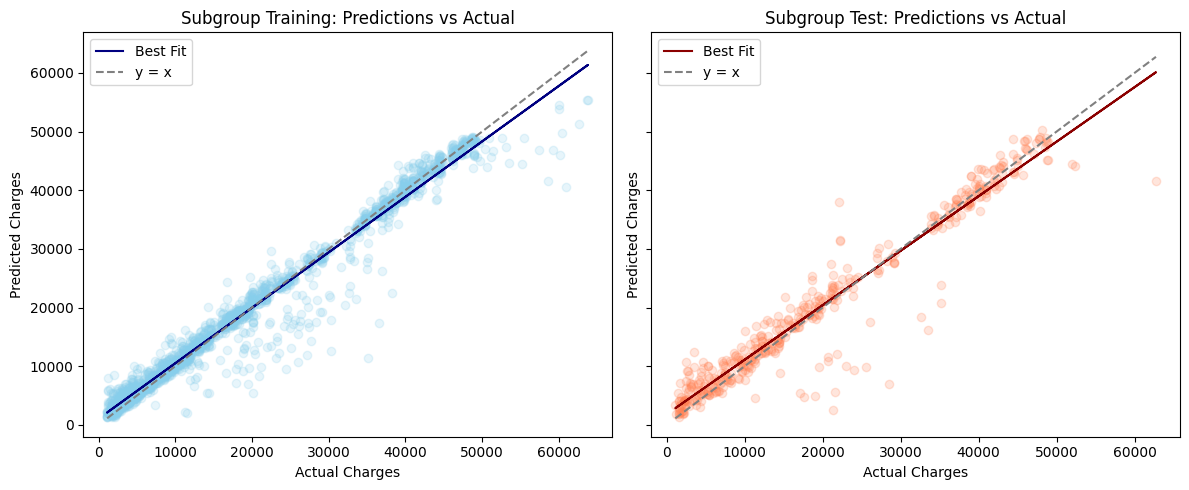


Note: Feature importance for the composite Hybrid Subgroup Model is not directly plotted here.
To inspect individual subgroup model importances, access `subgrp_model.non_smoker_model` and `subgrp_model.smoker_model`.

--- Collecting Group-wise Metrics for Hybrid Subgroup Model ---
✅ Hybrid Subgroup Model Evaluation Complete.


## **Step 4: Comparative Feature-wise Analysis** 📈⚖️🎯

Comparing MAE, MSE, and R² across Baseline, Fairlearn, and Hybrid Subgroup Models:


### Comparative Mean Absolute Error by Feature

,Feature,Group,Baseline MAE,Fairlearn MAE,Subgroup MAE
0,sex,0,2369.6413,2303.6061,2187.9654
1,sex,1,2277.2565,2290.9132,2423.6427
2,sex,Mean,2323.4489,2297.2597,2305.8041
3,sex,StdDev,46.1924,6.3465,117.8386
4,children,0,2412.4878,2346.3024,2359.8527
5,children,1,2034.7085,2037.2175,2036.3710
6,children,2,2553.5475,2570.7822,2539.8662
7,children,3,2202.1971,2224.9758,1848.6621
8,children,4,2919.0485,2654.8369,3481.4005
9,children,5,2343.5199,2662.0932,2634.4317


### Comparative Mean Squared Error by Feature

,Feature,Group,Baseline MSE,Fairlearn MSE,Subgroup MSE
0,sex,0,1.649285e+07,1.611614e+07,1.595977e+07
1,sex,1,1.261914e+07,1.245200e+07,1.414860e+07
2,sex,Mean,1.455600e+07,1.428407e+07,1.505419e+07
3,sex,StdDev,1.936858e+06,1.832070e+06,9.055824e+05
4,children,0,1.563178e+07,1.507055e+07,1.604075e+07
5,children,1,1.450826e+07,1.462684e+07,1.488342e+07
6,children,2,1.585712e+07,1.576950e+07,1.588406e+07
7,children,3,8.068739e+06,7.626447e+06,6.014745e+06
8,children,4,1.674696e+07,1.591201e+07,2.622685e+07
9,children,5,1.197681e+07,1.508605e+07,1.168489e+07


### Comparative R-squared by Feature

,Feature,Group,Baseline R2,Fairlearn R2,Subgroup R2
0,sex,0,0.9227,0.9245,0.9252
1,sex,1,0.9406,0.9414,0.9334
2,sex,Mean,0.9316,0.9329,0.9293
3,sex,StdDev,0.0089,0.0084,0.0041
4,children,0,0.9294,0.9319,0.9275
5,children,1,0.9317,0.9312,0.9299
6,children,2,0.9341,0.9344,0.9339
7,children,3,0.9380,0.9414,0.9538
8,children,4,0.7867,0.7973,0.6659
9,children,5,0.2347,0.0361,0.2534





**End of Comparative Analysis.**


In [7]:
# Up-sample data
y='smoker'
dfb = upsample_with_smote(df, y)


## Define pipeline parameters
target = 'charges';  hue = 'smoker'; stratify_by = ['smoker', 'sex']
key_features = ['sex','children','smoker','region_nw', 'region_se', 'region_sw']
metrics = {"MAE": mean_absolute_error, "MSE": mean_squared_error, "R2": r2_score}
model = define_xgb()
trainer = ModelTrainer(df=dfb, model=model, target=target, stratify_by=stratify_by)
model_results = trainer.run_fairness_comparison_pipeline()

#### 1.d Both upsampling, and feature-engineered data

1️⃣ Binning age and BMI...
2️⃣ Creating interaction features...
3️⃣ Adding behavioral flags...


,age,sex,bmi,children,smoker,charges,region_nw,region_se,region_sw,age_bin,bmi_bin,age__bmi,age__smoker,bmi__smoker,is_high_risk,is_young_smoker
0,18.973745,0,23.481596,2,0,2927.024610,0,0,1,0,0,445.980791,0.000000,0.000000,0,0
1,22.069776,0,21.350059,3,0,4301.147099,1,0,0,0,0,466.900715,0.000000,0.000000,0,0
2,21.003452,0,17.482771,1,0,2584.771388,0,0,1,0,0,365.026699,0.000000,0.000000,0,0
3,18.931313,0,24.671646,0,0,1738.937881,0,0,1,0,0,468.085238,0.000000,0.000000,0,0
4,19.038560,0,24.483258,1,0,2721.827034,1,0,0,0,0,467.652623,0.000000,0.000000,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2845,58.785839,0,36.755104,1,1,47883.209274,0,0,0,4,4,2178.685894,58.756234,36.586571,0,0
2846,57.824000,1,36.912500,2,1,47413.496148,1,0,0,4,4,2138.063600,57.842670,37.130342,0,0
2847,59.157764,1,41.020284,1,1,49012.871435,0,1,0,4,4,2429.563961,59.087950,40.972875,0,0
2848,59.185526,0,36.946773,1,1,47941.431987,0,0,0,4,4,2179.811143,59.183307,36.648555,0,0


- Generating dataframe column summary... done.


,Column,Type,Unique Counts,Min,Max,Unique Sample Values
0,age,float64,2850,17.91,64.32,"17.91, 17.91, 17.91, 17.91, 17.92 ... 64.3, 64..."
1,sex,int64,2,0.00,1.00,"0, 1"
2,bmi,float64,2850,16.04,52.80,"16.04, 16.79, 16.87, 17.13, 17.18 ... 52.35, 5..."
3,children,int64,6,0.00,5.00,"0, 1, 2, 3, 4..."
4,smoker,int64,2,0.00,1.00,"0, 1"
5,charges,float64,2850,1119.35,63886.33,"1119.35, 1131.1, 1133.09, 1133.14, 1134.54 ......"
6,region_nw,int32,2,0.00,1.00,"0, 1"
7,region_se,int32,2,0.00,1.00,"0, 1"
8,region_sw,int32,2,0.00,1.00,"0, 1"
9,age_bin,int64,5,0.00,4.00,"0, 1, 2, 3, 4"


🔧 Step 0: Initial Data Splitting (Stratified if possible)...
✅ Stratifying by combined columns: ['smoker', 'sex']


## **Step 1: Baseline Model Performance (Standard XGBoost)** 📊


📈 Training Baseline Model...
📊 Evaluating Baseline Model (Overall Test Set)...
RMSE: 1806.32 MAE: 827.23 R2: 0.99
RMSE: 2692.85 MAE: 1237.99 R2: 0.97
Overall Test RMSE: 2692.85
Overall Test MAE: 1237.99
Overall Test R2: 0.97

--- Visualizing Baseline Model Performance ---

📐 Baseline Training Best-Fit Line: y = 0.9692x + 619.45

📐 Baseline Test Best-Fit Line: y = 0.9525x + 1079.59


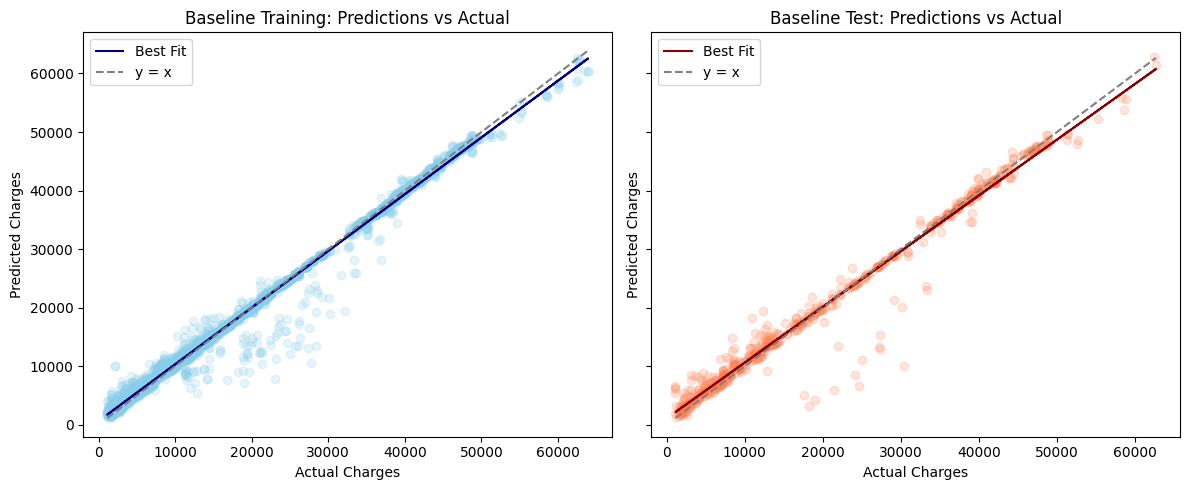

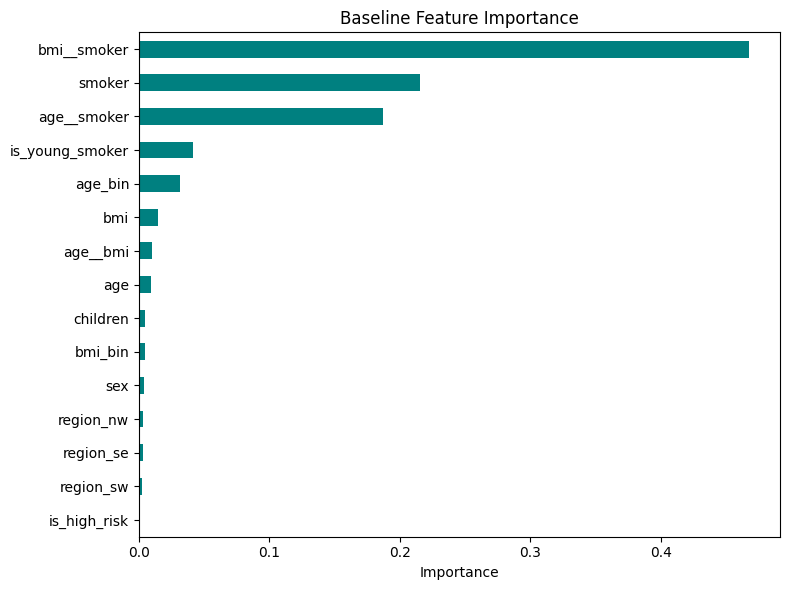


--- Collecting Group-wise Metrics for Baseline Model ---
✅ Baseline Model Evaluation Complete.


## **Step 2: Fairlearn-Constrained Model** ⚖️

✅ Dynamic `upper_bound` set to 1/3 of baseline training MAE: 275.74

📈 Training fairness-constrained model (constraints on ['smoker', 'sex'])...
This process may take longer due to fairness optimization.
⚠️ Unable to compute constraint violations on training set for Fair Model: ConditionalLossMoment.gamma() got an unexpected keyword argument 'sensitive_features'. This might happen with certain model types or if gamma calculation is complex. Safe to ignore if primarily using overall performance and group-wise metrics.

📊 Evaluating Fairlearn-Constrained Model (Overall Test Set)...
RMSE: 1862.72 MAE: 858.83 R2: 0.98
RMSE: 2631.99 MAE: 1225.54 R2: 0.97
Overall Test RMSE: 2631.99
Overall Test MAE: 1225.54
Overall Test R2: 0.97

--- Visualizing Fairlearn-Constrained Model Performance ---

📐 Fairlearn Training Best-Fit Line: y = 0.9680x + 645.14

📐 Fairlearn Test Best-Fit Line: y = 0.9550x + 1056.23


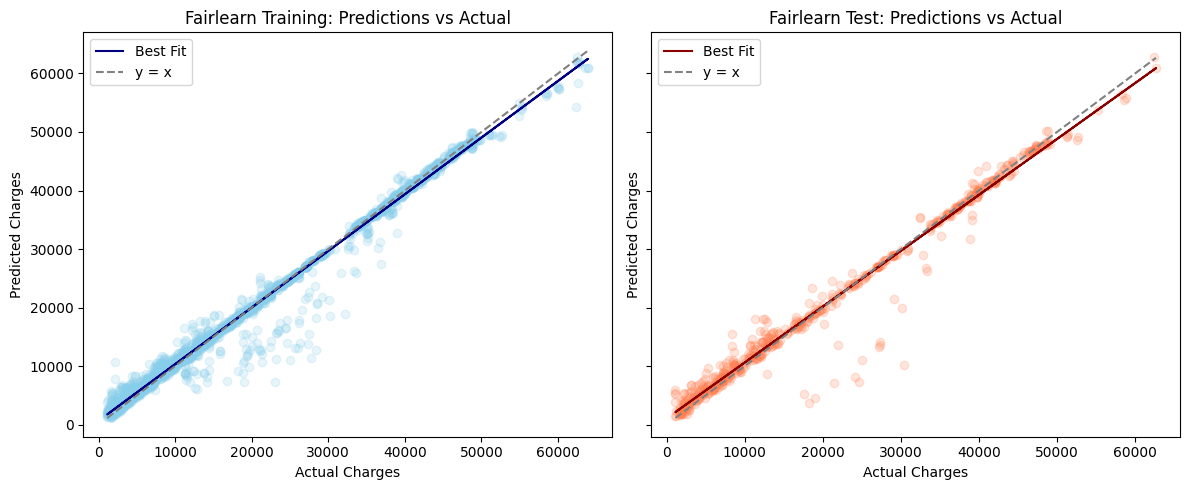


⚠️ Feature importance not available or empty for the Fairlearn model.

--- Collecting Group-wise Metrics for Fairlearn-Constrained Model ---
✅ Fairlearn Model Evaluation Complete.


## **Step 3: Hybrid Subgroup Model** 🎯


📈 Training Hybrid Subgroup Model...
🚀 Starting Hybrid Subgroup Model Training:
Non-smoker data points: 1140
Smoker data points: 1140
--------------------------------------------------

--- Training Standard Model for NON-SMOKERS ---
✅ Stratifying by combined columns: ['smoker', 'sex']
RMSE: 1896.48 MAE: 950.96 R2: 0.89

--- Training FAIRNESS-AWARE Model for SMOKERS ---
✅ Stratifying by combined columns: ['smoker', 'sex']
RMSE: 790.13 MAE: 374.86 R2: 1.00
✅ Dynamic `upper_bound` set to 1/3 of baseline training MAE: 124.95

📈 Training fairness-constrained model (constraints on ['smoker', 'sex'])...
This process may take longer due to fairness optimization.
⚠️ Unable to compute constraint violations on training set for Fair Model: ConditionalLossMoment.gamma() got an unexpected keyword argument 'sensitive_features'. This might happen with certain model types or if gamma calculation is complex. Safe to ignore if primarily using overall performance and group-wise metrics.

✅ Hybrid Subgrou

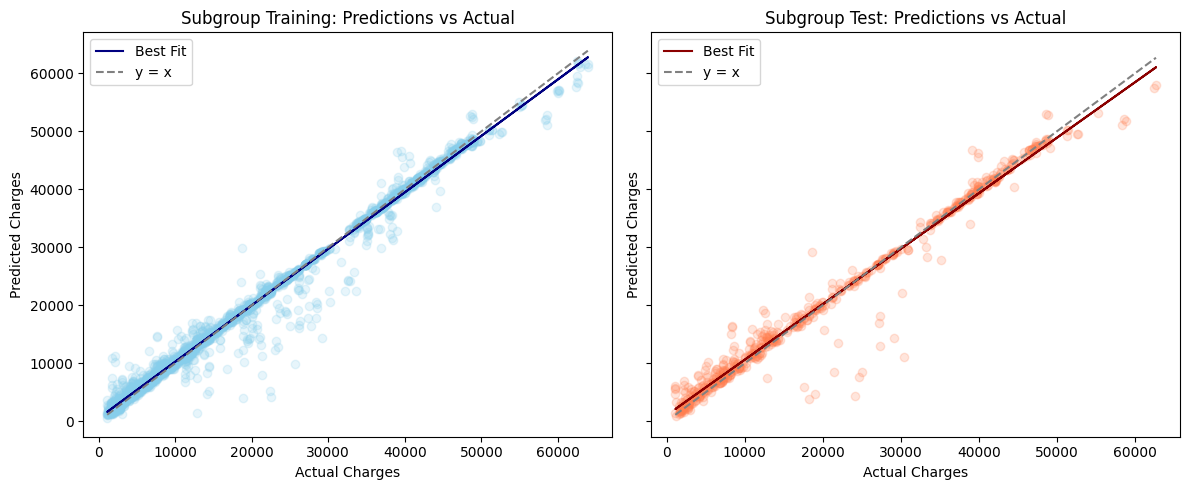


Note: Feature importance for the composite Hybrid Subgroup Model is not directly plotted here.
To inspect individual subgroup model importances, access `subgrp_model.non_smoker_model` and `subgrp_model.smoker_model`.

--- Collecting Group-wise Metrics for Hybrid Subgroup Model ---
✅ Hybrid Subgroup Model Evaluation Complete.


## **Step 4: Comparative Feature-wise Analysis** 📈⚖️🎯

Comparing MAE, MSE, and R² across Baseline, Fairlearn, and Hybrid Subgroup Models:


### Comparative Mean Absolute Error by Feature

,Feature,Group,Baseline MAE,Fairlearn MAE,Subgroup MAE
0,sex,0,1313.3729,1234.6217,1357.9164
1,sex,1,1169.6583,1217.3076,1242.9042
2,sex,Mean,1241.5156,1225.9646,1300.4103
3,sex,StdDev,71.8573,8.6570,57.5061
4,children,0,1148.6909,1111.4669,1168.4082
5,children,1,1312.9730,1209.6343,1361.8577
6,children,2,1416.5567,1481.0061,1637.8567
7,children,3,837.8627,954.9277,823.2505
8,children,4,3398.4025,3270.3255,3071.6437
9,children,5,989.1510,1057.3295,852.1480


### Comparative Mean Squared Error by Feature

,Feature,Group,Baseline MSE,Fairlearn MSE,Subgroup MSE
0,sex,0,8.694181e+06,7.796110e+06,9.882792e+06
1,sex,1,5.943834e+06,6.139985e+06,6.029819e+06
2,sex,Mean,7.319008e+06,6.968047e+06,7.956306e+06
3,sex,StdDev,1.375174e+06,8.280624e+05,1.926487e+06
4,children,0,5.958896e+06,5.408597e+06,5.628727e+06
5,children,1,7.878337e+06,6.875133e+06,8.168751e+06
6,children,2,9.960329e+06,1.023530e+07,1.348044e+07
7,children,3,1.677537e+06,2.589990e+06,1.738046e+06
8,children,4,4.370330e+07,4.107899e+07,3.807067e+07
9,children,5,1.409379e+06,1.891981e+06,8.171366e+05


### Comparative R-squared by Feature

,Feature,Group,Baseline R2,Fairlearn R2,Subgroup R2
0,sex,0,0.9601,0.9642,0.9547
1,sex,1,0.9763,0.9755,0.9759
2,sex,Mean,0.9682,0.9699,0.9653
3,sex,StdDev,0.0081,0.0056,0.0106
4,children,0,0.9744,0.9768,0.9758
5,children,1,0.9729,0.9763,0.9719
6,children,2,0.9561,0.9549,0.9406
7,children,3,0.9914,0.9868,0.9911
8,children,4,0.5427,0.5702,0.6016
9,children,5,0.9419,0.9220,0.9663





**End of Comparative Analysis.**


In [8]:
# Convert selected columns to categorical

from transformation import *
dff = transform_data(df)   # transformation returns engineered dataset

dff.to_csv('feature_engineered_dataset.csv', index=False)  # Save for traceability
display(dff)
display(describe_column_stats(dff))


## Define pipeline parameters
target = 'charges';  hue = 'smoker'; stratify_by = ['smoker', 'sex']
key_features = ['sex','children','smoker','region_nw', 'region_se', 'region_sw']
metrics = {"MAE": mean_absolute_error, "MSE": mean_squared_error, "R2": r2_score}
model = define_xgb()
trainer = ModelTrainer(df=dff, model=model, target=target, stratify_by=stratify_by)
model_results = trainer.run_fairness_comparison_pipeline()